## LOAD A DATASET WITH ALL FEATURES: PROCEDURE, AFFECTIVE SCORE, EMOTIONS, PERSONALITY ETC.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from numpy import mean,std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold,cross_val_score,KFold,train_test_split
from sklearn.preprocessing import StandardScaler,MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Activation,Flatten,MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import normalize, to_categorical
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)
path='emo_personality_procedure_df.csv'
df_full = pd.read_csv(path,converters={'SEC_EMO': eval,'FIRST_EMO':eval})


In [3]:
df_full

,SUB_NAME,STIMULI,FRAME_NUMBER,IADS_ID,IAPS_ID,ANGER,CONTEMPT,DISGUST,FEAR,HAPPINESS,NEUTRAL,SADNESS,SURPRISE,FIRST_EMO,SEC_EMO,MEAN_ABS_ERR,MEAN_SQ_ERR,ENERGY,WASSERSTEIN,RELATIVE_ENTROPY,JENSENSHANNON,HELLINGER,BHATTACHARYYA_DIST,CORRELATION,COND,ANS_VALENCE,ANS_AROUSAL,OPENNESS,CONSCIENTIOUSNESS,NEUROTICISM,AGREEABLENESS,EXTRAVERSION
0,SUB103,SUB103_102_None,300,102,None,0.001,0.207,0.0,0.0,0.000,0.789,0.003,0.0,[NEUTRAL],[CONTEMPT],0.052750,0.010922,0.116190,0.052750,inf,0.281714,0.334280,0.118494,3.436184e-02,S0,6.582,5.00,6,6,2,3,4
1,SUB103,SUB103_102_None,195,102,None,0.000,0.022,0.0,0.0,0.000,0.974,0.003,0.0,[NEUTRAL],[CONTEMPT],0.006375,0.000146,0.042205,0.006375,inf,0.093554,0.112186,0.013172,2.448778e-04,S0,6.582,5.00,6,6,2,3,4
2,SUB103,SUB103_102_None,225,102,None,0.000,0.001,0.0,0.0,0.000,0.985,0.014,0.0,[NEUTRAL],[SADNESS],0.003750,0.000053,0.031623,0.003750,inf,0.072298,0.086766,0.007557,9.750467e-05,S0,6.582,5.00,6,6,2,3,4
3,SUB103,SUB103_102_None,120,102,None,0.000,0.000,0.0,0.0,0.000,0.992,0.008,0.0,[NEUTRAL],[SADNESS],0.002000,0.000016,0.022361,0.002000,inf,0.052732,0.063309,0.004016,3.192657e-05,S0,6.582,5.00,6,6,2,3,4
4,SUB103,SUB103_102_None,210,102,None,0.000,0.000,0.0,0.0,0.000,0.993,0.006,0.0,[NEUTRAL],[SADNESS],0.001625,0.000011,0.020156,0.001625,inf,0.045673,0.054828,0.003512,1.791256e-05,S0,6.582,5.00,6,6,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256975,SUB997,SUB997_None_9594,45,None,9594,0.000,0.000,0.0,0.0,0.002,0.996,0.002,0.0,[NEUTRAL],"[HAPPINESS, SADNESS]",0.001000,0.000003,0.019365,0.001000,inf,0.037260,0.044744,0.002004,3.295350e-06,P0,5.052,6.08,1,3,7,4,1
256976,SUB997,SUB997_None_9594,150,None,9594,0.000,0.001,0.0,0.0,0.001,0.997,0.001,0.0,[NEUTRAL],"[CONTEMPT, HAPPINESS, SADNESS]",0.000750,0.000002,0.019365,0.000750,inf,0.032262,0.038744,0.001502,9.863423e-07,P0,5.052,6.08,1,3,7,4,1
256977,SUB997,SUB997_None_9594,225,None,9594,0.000,0.001,0.0,0.0,0.002,0.997,0.000,0.0,[NEUTRAL],[HAPPINESS],0.000750,0.000002,0.015811,0.000750,inf,0.032262,0.038744,0.001502,2.137071e-06,P0,5.052,6.08,1,3,7,4,1
256978,SUB997,SUB997_None_9594,270,None,9594,0.000,0.001,0.0,0.0,0.002,0.997,0.001,0.0,[NEUTRAL],[HAPPINESS],0.000875,0.000002,0.020156,0.000875,inf,0.037241,0.044734,0.001502,2.137684e-06,P0,5.052,6.08,1,3,7,4,1


In [4]:
df_full.drop('RELATIVE_ENTROPY',axis=1,inplace=True)

## take only least neutral row from each stimuli
#### This is ordered dataset; by stimuli and neutral emotion asc so I can grab it

In [5]:
first_only_df=df_full.groupby('STIMULI').first().reset_index()

#### Now, shuffle it

In [6]:
first_only_df = first_only_df.sample(frac=1).reset_index(drop=True)

In [7]:
first_only_df

,STIMULI,SUB_NAME,FRAME_NUMBER,IADS_ID,IAPS_ID,ANGER,CONTEMPT,DISGUST,FEAR,HAPPINESS,NEUTRAL,SADNESS,SURPRISE,FIRST_EMO,SEC_EMO,MEAN_ABS_ERR,MEAN_SQ_ERR,ENERGY,WASSERSTEIN,JENSENSHANNON,HELLINGER,BHATTACHARYYA_DIST,CORRELATION,COND,ANS_VALENCE,ANS_AROUSAL,OPENNESS,CONSCIENTIOUSNESS,NEUROTICISM,AGREEABLENESS,EXTRAVERSION
0,SUB383_244_2811,SUB383,240,244,2811,0.000,0.000,0.0,0.000,0.0,0.998,0.001,0.00,[NEUTRAL],[SADNESS],0.000375,6.250000e-07,0.009682,0.000375,0.018629,0.022372,0.001001,4.919014e-07,PS-,2.602,6.307,4,8,7,8,4
1,SUB465_None_6610,SUB465,0,None,6610,0.013,0.022,0.0,0.000,0.0,0.963,0.001,0.00,[NEUTRAL],[CONTEMPT],0.009125,2.528750e-04,0.056734,0.009125,0.112492,0.134811,0.018851,2.918844e-04,P0,3.599,2.894,7,5,5,3,6
2,SUB829_None_1945,SUB829,0,None,1945,0.000,0.001,0.0,0.000,0.0,0.951,0.048,0.00,[NEUTRAL],[SADNESS],0.012250,5.882500e-04,0.055902,0.012250,0.131491,0.157505,0.025121,1.255736e-03,P0,3.120,3.725,5,9,6,10,7
3,SUB959_808_7230,SUB959,180,808,7230,0.000,0.000,0.0,0.000,0.0,0.999,0.000,0.00,[NEUTRAL],"[ANGER, CONTEMPT, DISGUST, FEAR, HAPPINESS, SA...",0.000125,1.250000e-07,0.005590,0.000125,0.000002,0.000354,0.000500,1.110223e-16,PS+,4.132,5.698,8,7,2,8,4
4,SUB208_713_3140,SUB208,30,713,3140,0.000,0.000,0.0,0.000,0.0,0.974,0.026,0.00,[NEUTRAL],[SADNESS],0.006500,1.690000e-04,0.040311,0.006500,0.095376,0.114392,0.013172,3.515067e-04,PS-,2.216,7.059,5,4,7,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,SUB267_365_8206,SUB267,195,365,8206,0.000,0.006,0.0,0.000,0.0,0.994,0.000,0.00,[NEUTRAL],[CONTEMPT],0.001500,9.000000e-06,0.019365,0.001500,0.045650,0.054813,0.003009,1.787650e-05,PS+,4.568,3.596,6,8,8,6,3
11013,SUB333_None_7484,SUB333,15,None,7484,0.001,0.000,0.0,0.083,0.0,0.825,0.011,0.08,[NEUTRAL],[FEAR],0.043750,5.504500e-03,0.132288,0.043750,0.254661,0.302828,0.096186,7.971516e-03,P0,4.029,2.819,7,9,2,2,3
11014,SUB211_290_None,SUB211,330,290,None,0.000,0.001,0.0,0.000,0.0,0.880,0.119,0.00,[NEUTRAL],[SADNESS],0.030000,3.570250e-03,0.086963,0.030000,0.208579,0.248831,0.063917,9.163101e-03,S-,1.000,8.438,5,10,5,5,7
11015,SUB200_378_5626,SUB200,180,378,5626,0.000,0.000,0.0,0.000,0.0,0.809,0.190,0.00,[NEUTRAL],[SADNESS],0.047625,9.072625e-03,0.109116,0.047625,0.266310,0.316316,0.105978,2.772725e-02,PS+,6.552,6.110,3,8,7,1,2


### Define input and output for model testing

Input to be tested:

    1.emotion distribution only
    2.emotion distribution + personality traits
    3.chosen statistical distances + categorical data of first and second most recognized emotion + personality traits
   
Output to be tested (val/arousal):

    1.continous --> regression problem
    2.categorical --> classification problem: LOW,MODERATE,HIGH VxA (VALUES ARE 1-9 ORGINALLY)
                                              or LOW,HIGH VxA
        
    
    
    
    

### Input 1

In [8]:
emo_only_df=first_only_df[['ANGER','CONTEMPT','DISGUST','FEAR','HAPPINESS','NEUTRAL','SADNESS','SURPRISE']]

### Input 2

In [9]:
emo_personality_df=first_only_df[['ANGER','CONTEMPT','DISGUST','FEAR','HAPPINESS','NEUTRAL','SADNESS','SURPRISE','OPENNESS','CONSCIENTIOUSNESS','NEUROTICISM','AGREEABLENESS','EXTRAVERSION']]

### input 3

#### chosen stat distances: 
we could choose the useful ones based on its st dev and mean. the more deviation the more "active" the measure is and perhaps can yield best results
also it would be good to exclude correlation effects between those we use

In [10]:
distances_lst=['MEAN_ABS_ERR','MEAN_SQ_ERR','ENERGY','WASSERSTEIN','JENSENSHANNON','HELLINGER','BHATTACHARYYA_DIST','CORRELATION']
#distances_lst=['MEAN_ABS_ERR']
for dist in distances_lst:
    dist_df=first_only_df[dist]
    print(dist, 'std: ',dist_df.std(),'  mean: ',dist_df.mean())

MEAN_ABS_ERR std:  0.05871694138854942   mean:  0.047254527094490156
MEAN_SQ_ERR std:  0.049869753702819715   mean:  0.021872283890805144
ENERGY std:  0.048041340573577174   mean:  0.08339113610596843
WASSERSTEIN std:  0.03412057343278713   mean:  0.03428191658346192
JENSENSHANNON std:  0.17960019611312467   mean:  0.2332994236072252
HELLINGER std:  0.20814392916338756   mean:  0.2751948796526792
BHATTACHARYYA_DIST std:  0.7715897503421415   mean:  0.19184335772446023
CORRELATION std:  0.25794473605979784   mean:  0.1071791640690879


In [11]:
#first_only_df['BHATTACHARYYA_DIST'].corr(first_only_df['HELLINGER'])
for dist_1 in distances_lst:
    dist_1_df=first_only_df[dist_1]
    for dist_2 in distances_lst:
        dist_2_df=first_only_df[dist_2]
        print('pearson corr btween ', dist_1,'and ', dist_2, 'is: ', dist_1_df.corr(dist_2_df))
    print('##############')    

pearson corr btween  MEAN_ABS_ERR and  MEAN_ABS_ERR is:  1.0
pearson corr btween  MEAN_ABS_ERR and  MEAN_SQ_ERR is:  0.9382144692559544
pearson corr btween  MEAN_ABS_ERR and  ENERGY is:  0.5456154538048086
pearson corr btween  MEAN_ABS_ERR and  WASSERSTEIN is:  0.5848687965958042
pearson corr btween  MEAN_ABS_ERR and  JENSENSHANNON is:  0.9873156461250121
pearson corr btween  MEAN_ABS_ERR and  HELLINGER is:  0.9850048792383163
pearson corr btween  MEAN_ABS_ERR and  BHATTACHARYYA_DIST is:  0.5255459362234071
pearson corr btween  MEAN_ABS_ERR and  CORRELATION is:  0.9379683098335648
##############
pearson corr btween  MEAN_SQ_ERR and  MEAN_ABS_ERR is:  0.9382144692559544
pearson corr btween  MEAN_SQ_ERR and  MEAN_SQ_ERR is:  0.9999999999999999
pearson corr btween  MEAN_SQ_ERR and  ENERGY is:  0.22647555649781329
pearson corr btween  MEAN_SQ_ERR and  WASSERSTEIN is:  0.2771717395465839
pearson corr btween  MEAN_SQ_ERR and  JENSENSHANNON is:  0.8923657908319991
pearson corr btween  MEAN_SQ

I will go with BHATTACHARYYA_DIST and HELLINGER: 0.5 correlation (moderate) and and highest std  

In [12]:
dist_df=first_only_df[['BHATTACHARYYA_DIST','HELLINGER']]

#### hot-one encode first and second highest recognized emotion labels

In [13]:
mlb = MultiLabelBinarizer()

hot_one_f=pd.DataFrame(mlb.fit_transform(first_only_df.FIRST_EMO),columns=mlb.classes_, index=first_only_df.index)
hot_one_s=pd.DataFrame(mlb.fit_transform(first_only_df.SEC_EMO),columns=mlb.classes_, index=first_only_df.index)

hot_one_f.rename({    
    'ANGER':'ANGER_F',
    'CONTEMPT':'CONTEMPT_F',
    'DISGUST':'DISGUST_F',
    'FEAR':'FEAR_F',
    'HAPPINESS':'HAPPINESS_F',
    'NEUTRAL':'NEUTRAL_F',
    'SADNESS':'SADNESS_F',    
    }, axis=1, inplace=True)

hot_one_s.rename({    
    'ANGER':'ANGER_S',
    'CONTEMPT':'CONTEMPT_S',
    'DISGUST':'DISGUST_S',
    'FEAR':'FEAR_S',
    'HAPPINESS':'HAPPINESS_S',
    'NEUTRAL':'NEUTRAL_S',
    'SADNESS':'SADNESS_S',    
    }, axis=1, inplace=True)


hot_one_both=pd.merge(hot_one_f, hot_one_s, left_index=True, right_index=True)

In [14]:
personality_df=first_only_df[['OPENNESS','CONSCIENTIOUSNESS','NEUROTICISM','AGREEABLENESS','EXTRAVERSION']]

In [15]:
stat_cat_pers_df=pd.merge(dist_df, hot_one_both, left_index=True, right_index=True)
stat_cat_pers_df=pd.merge(stat_cat_pers_df, personality_df, left_index=True, right_index=True)

### outputs

In [18]:
y_df=first_only_df[['ANS_VALENCE','ANS_AROUSAL']]

In [19]:
def to_cat(val):
    if val >=1 and val <3:
        return 'LOW'
    elif val >=3 and val <6:
        return 'MODERATE'
    elif val >=6 and val <=9:
        return 'HIGH'
def to_cat2(val):
    if val >=1 and val <5:
        return 'LOW'
    elif val >=5 and val <=9:
        return 'HIGH'
    
def to_num(key):
    classes={
    'LOW VALENCE LOW AROUSAL':0,
    'LOW VALENCE MODERATE AROUSAL':1,
    'LOW VALENCE HIGH AROUSAL':2,
    'MODERATE VALENCE LOW AROUSAL':3,
    'MODERATE VALENCE MODERATE AROUSAL':4,
    'MODERATE VALENCE HIGH AROUSAL':5,
    'HIGH VALENCE LOW AROUSAL':6,
    'HIGH VALENCE MODERATE AROUSAL':7,
    'HIGH VALENCE HIGH AROUSAL':8,
    }
    return classes.get(key)

def to_num2(key):
    classes={
    'LOW VALENCE LOW AROUSAL':0,
    'LOW VALENCE HIGH AROUSAL':1,
    'HIGH VALENCE LOW AROUSAL':2,
    'HIGH VALENCE HIGH AROUSAL':3,
    }
    return classes.get(key)

y_df['AROUSAL_VAL_CAT'] = y_df.apply(lambda row: to_cat(row['ANS_VALENCE']) +' VALENCE '+ to_cat(row['ANS_AROUSAL']) + ' AROUSAL' , axis=1)
y_df['VAL_AR_NUM']=y_df.apply(lambda row: to_num(row['AROUSAL_VAL_CAT']), axis=1)

y_df['AROUSAL_VAL_CAT2'] = y_df.apply(lambda row: to_cat2(row['ANS_VALENCE']) +' VALENCE '+ to_cat2(row['ANS_AROUSAL']) + ' AROUSAL' , axis=1)
y_df['VAL_AR_NUM2']=y_df.apply(lambda row: to_num2(row['AROUSAL_VAL_CAT2']), axis=1)

C:\Users\bartk\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bartk\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bartk\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

# Regression approach

### X and y

In [ ]:
input_lst=[
    (emo_only_df,'emotion only'),
    (emo_personality_df, 'emotion + personality'),
    (stat_cat_pers_df, 'stat distanes + emotion labels')
]

input_lst_transform=[]
for X,name in input_lst:
    X=X.to_numpy()
    scaler=StandardScaler()
    scaler.fit(X)
    X=scaler.transform(X)
    res=(X,name)
    input_lst_transform.append(res)
    
    
y=y_df[['ANS_VALENCE','ANS_AROUSAL']].to_numpy()    

### Train NN model

In [ ]:
units=[5,10,15,20,30,40,50]
activations_last_layer=['linear','relu']
epochs=[20,40]
y=y_df[['ANS_VALENCE','ANS_AROUSAL']].to_numpy()

def NN_regression(n_inputs, n_outputs,unit,activation):
    
    model = Sequential()
    model.add(Dense(unit, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs,activation=activation))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
    return model

with open('ModelsResults.txt', 'w') as file:
            file.write('Regression Approach:\nNEURAL NETWORK- 2 dense layers (input and output)'.format(input_[1]))

for input_ in input_lst_transform:
    
    X_train, X_test, y_train, y_test = train_test_split(input_[0], y, test_size = 0.2, random_state = 42)
    with open('ModelsResults.txt', 'a') as file:
                file.write('\n Input used: {}'.format(input_[1]))
    for unit in units:
        for activation in activations_last_layer:
            for epoch_n in epochs:
                model=NN_regression(X_train.shape[1], y_train.shape[1],unit,activation)
                history = model.fit(X_train, y_train, validation_split=0.2, epochs =epoch_n,verbose=0)
                mse_neural, mae_neural = model.evaluate(X_test, y_test)
                with open('ModelsResults.txt', 'a') as file:
                    file.write("""\n\n\t Configuration: {} units, {} activation function on output layer, {} epochs
                                   \n\t\t Mean squared error from neural net: {}
                                   \n\t\t Mean absolute error from neural net: {}""".format(unit,activation,
                                                                                            epoch_n,mse_neural,mae_neural))
#     print('Mean squared error from neural net: ', mse_neural)
#     print('Mean absolute error from neural net: ', mae_neural)

In [ ]:
# acc = history.history['mae']
# val_acc = history.history['val_mae']
# plt.plot(epochs, acc, 'y', label='Training MAE')
# plt.plot(epochs, val_acc, 'r', label='Validation MAE')
# plt.title('Training and validation MAE')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()

In [ ]:
# Prediction: 
# predictions = model.predict(X_test[15:20:])
# print("Predicted values are:\n\n", predictions)
# print("\nReal values are:\n\n", y_test[15:20:])

### Random  Forest

In [ ]:
#Find good parameters by randomly choosing combination of parameters. Save the best ones and write an estimation to txt file.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
best_random_lst=[]
for input_ in input_lst_transform:
    X_train, X_test, y_train, y_test = train_test_split(input_[0], y, test_size = 0.2, random_state = 42)

    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, 
                                   verbose=1, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    res=(input_[1],rf_random.best_estimator_)
    best_random_lst.append(res)

In [ ]:
with open('RandomForestRegression.txt', 'w') as file:
    file.write("RandomForestRegression")


for name, model in best_random_lst:
    with open('RandomForestRegression.txt', 'a') as file:
        file.write("\n\nInput data used: {}\nmodel parameters used: {}\n\n".format(name,model))
    
    for data,ds_name in input_lst_transform:
        if ds_name == name:
            X = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    model.fit(X_train, y_train)
    y_pred_RF = model.predict(X_test)
    mse_RF = mean_squared_error(y_test, y_pred_RF)
    mae_RF = mean_absolute_error(y_test, y_pred_RF)
    with open('RandomForestRegression.txt', 'a') as file:
        file.write("Results\n\t'Mean squared error using Random Forest: {}'\n\t'Mean absolute error using Random Forest: {}".format(mse_RF,mae_RF))
    

### SVR

In [ ]:
xd = MultiOutputRegressor(SVR())
xd.get_params().keys()

In [ ]:
# try out how different kernels and C, gamma values affect the results. 

In [ ]:
# defining parameter range
param_grid = {'estimator__C': [0.1, 1, 10, 100, 1000], 
              'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'estimator__kernel': ['linear','rbf','sigmoid']} 

best_estimator_lst = []
for input_ in input_lst_transform:
    X_train, X_test, y_train, y_test = train_test_split(input_[0], y, test_size = 0.2, random_state = 42)
    grid = GridSearchCV(MultiOutputRegressor(SVR()), param_grid, cv=5, verbose = 3,n_jobs=-1)
    grid.fit(X_train, y_train)
    res=(input_[1],grid.best_estimator_)
    best_estimator_lst.append(res)

In [ ]:
with open('SupportVectorRegression.txt', 'w') as file:
    file.write("SupportVectorRegression")


for name, model in best_estimator_lst:
    with open('SupportVectorRegression.txt', 'a') as file:
        file.write("\n\nInput data used: {}\nmodel parameters used: {}\n\n".format(name,model))
    
    for data,ds_name in input_lst_transform:
        if ds_name == name:
            X = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
        
    model.fit(X_train, y_train)
    y_pred_SVR = model.predict(X_test)
    mse_SVR = mean_squared_error(y_test, y_pred_SVR)
    mae_SVR = mean_absolute_error(y_test, y_pred_SVR)
    with open('SupportVectorRegression.txt', 'a') as file:
        file.write("Results\n\t'Mean squared error using SVR: {}'\n\t'Mean absolute error using SVR: {}".format(mse_SVR,mae_SVR))

# CLASSIFICATION APPROACH

In [20]:
val_ar_size=y_df.groupby(by='AROUSAL_VAL_CAT').size().sort_values()
print('9 CATEGORIES')
print(val_ar_size)
print()
val_ar_size2=y_df.groupby(by='AROUSAL_VAL_CAT2').size().sort_values()
print('4 CATEGORIES')
print(val_ar_size2)


9 CATEGORIES
AROUSAL_VAL_CAT
LOW VALENCE LOW AROUSAL               289
HIGH VALENCE LOW AROUSAL              372
MODERATE VALENCE LOW AROUSAL          694
MODERATE VALENCE HIGH AROUSAL        1064
LOW VALENCE MODERATE AROUSAL         1189
HIGH VALENCE HIGH AROUSAL            1475
HIGH VALENCE MODERATE AROUSAL        1600
LOW VALENCE HIGH AROUSAL             2005
MODERATE VALENCE MODERATE AROUSAL    2329
dtype: int64

4 CATEGORIES
AROUSAL_VAL_CAT2
LOW VALENCE LOW AROUSAL      1604
HIGH VALENCE LOW AROUSAL     1789
HIGH VALENCE HIGH AROUSAL    3550
LOW VALENCE HIGH AROUSAL     4074
dtype: int64


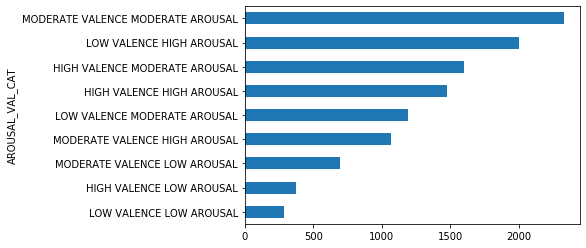

In [21]:
val_ar_size.plot.barh()

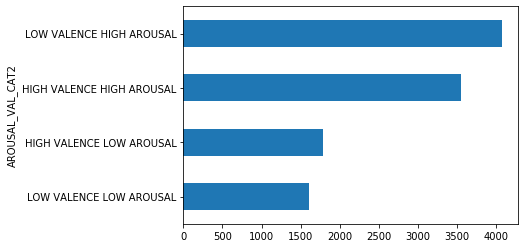

In [22]:
val_ar_size2.plot.barh()

In [23]:
input_lst=[
    (emo_only_df,'emotion only'),
    (emo_personality_df, 'emotion + personality'),
    (stat_cat_pers_df, 'stat distanes + emotion labels')
]

input_lst_transform=[]
for X,name in input_lst:
    X=X.to_numpy()
    scaler=StandardScaler()
    scaler.fit(X)
    X=scaler.transform(X)
    res=(X,name)
    input_lst_transform.append(res)

output_lst=[
    (y_df[['VAL_AR_NUM']].to_numpy(),'9 Categories'),
    (y_df[['VAL_AR_NUM2']].to_numpy(),'4 Categories')
]

### NN

In [ ]:
units=[5,10,15,20,30,40,50]
epochs=[20,40]


def NN_classifier(n_inputs, n_outputs,unit):
    
    model = Sequential()
    model.add(Dense(unit, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

with open('NeuralNetClassifier.txt', 'w') as file:
            file.write('Classification Approach:\nNEURAL NETWORK- 2 dense layers (input and output)')

for input_,name_i in input_lst_transform:
    for output,name_o in output_lst:
        y=to_categorical(output)
        X_train, X_test, y_train, y_test = train_test_split(input_, y, test_size = 0.2, random_state = 42)
        with open('NeuralNetClassifier.txt', 'a') as file:
                    file.write('\n Input used: {},\noutput used: {}'.format(name_i,name_o))
        for unit in units:
            for epoch_n in epochs:
                model=NN_classifier(X_train.shape[1], y_train.shape[1],unit)
                history = model.fit(X_train, y_train, validation_split=0.2, epochs =epoch_n,verbose=0)
                loss_neural, acc_neural = model.evaluate(X_test, y_test)
                with open('NeuralNetClassifier.txt', 'a') as file:
                    file.write("""\n\n\t Configuration: {} units, {} epochs
                                   \n\t\t Loss: {}\n\t\t Accuracy: {}""".format(unit,epoch_n,loss_neural,acc_neural))

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

### Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
best_random_lst=[]
for input_,name_i in input_lst_transform:
    for output,name_o in output_lst:
        output=to_categorical(output)
        X_train, X_test, y_train, y_test = train_test_split(input_, output, test_size = 0.2, random_state = 42)

        rf = RandomForestClassifier()
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, 
                                       verbose=1, random_state=42, n_jobs = -1)
        rf_random.fit(X_train, y_train)
        res=(name_i,name_o,rf_random.best_estimator_)
        best_random_lst.append(res)

In [ ]:
with open('RandomForestClassification.txt', 'w') as file:
    file.write("RandomForestClassification")


for name_in_best,name_out_best, model in best_random_lst:
    for data_in,ds_name_in in input_lst_transform:
        if ds_name_in == name_in_best:
            X = data_in

    for data_out,ds_name_out in output_lst:
        if ds_name_out == name_out_best:
            y = data_out

    y=to_categorical(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    with open('RandomForestClassification.txt', 'a') as file:
        file.write("\n\nInput data used: {}\noutput data used: {}\nmodel parameters used: {}\n\n".format(name_in_best,name_out_best,model))
    
    model.fit(X_train, y_train)
    y_pred_RF = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_RF)
    with open('RandomForestClassification.txt', 'a') as file:
        file.write("Results\n\t'Accuracy using Random Forest: {}".format(acc))
    

### SVM

In [ ]:
# defining parameter range
#Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it:
# it takes forever for 'linear' kernel+big values of C so not going to try it 
#One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.
param_grid = {'C': [0.001,0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001,'scale','auto'],
              'kernel': ['rbf','sigmoid'],
              'class_weight':['balanced',None]} 

best_estimator_lst = []
for input_,name_i in input_lst_transform:
    for output,name_o in output_lst:
        X_train, X_test, y_train, y_test = train_test_split(input_, output.ravel(), test_size = 0.2, random_state = 42)
        grid = GridSearchCV((SVC()), param_grid, cv=5, verbose = 3,n_jobs=-1)
        grid.fit(X_train, y_train)
        res=(name_i,name_o,grid.best_estimator_)
        best_estimator_lst.append(res)

In [ ]:
with open('SupportVectorClassification.txt', 'w') as file:
    file.write("SupportVectorClassification")


for name_in_best,name_out_best, model in best_estimator_lst:
    for data_in,ds_name_in in input_lst_transform:
        if ds_name_in == name_in_best:
            X = data_in
    for data_out,ds_name_out in output_lst:
        if ds_name_out == name_out_best:
            y = data_out       
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size = 0.2, random_state = 42)
    with open('SupportVectorClassification.txt', 'a') as file:
        file.write("\n\nInput data used: {}Output data used: {}\nmodel parameters used: {}\n\n".format(name_in_best,name_out_best,model))
           
    model.fit(X_train, y_train)
    y_pred_SVM = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred_SVM)
    with open('SupportVectorClassification.txt', 'a') as file:
        file.write("Results\n\tAccuracy using SVM: {}".format(acc))

#### Dummy y

In [48]:
input_lst=[
    (emo_only_df,'emotion only'),
    (emo_personality_df, 'emotion + personality'),
    (stat_cat_pers_df, 'stat distanes + emotion labels')
]

input_lst_transform=[]
for X,name in input_lst:
    X=X.to_numpy()
    scaler=StandardScaler()
    scaler.fit(X)
    X=scaler.transform(X)
    res=(X,name)
    input_lst_transform.append(res)

output_lst=[
    (y_df[['VAL_AR_NUM']].to_numpy(),'9 Categories'),
    (y_df[['VAL_AR_NUM2']].to_numpy(),'4 Categories')
]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(input_lst_transform[1][0], output_lst[1][0].ravel(), test_size = 0.2, random_state = 42)

sv=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
sv.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [62]:
dummy_y= np.full((2204, 1), 1, dtype=int)

y_pred_SVM = sv.predict(X_test)
acc=accuracy_score(y_test, dummy_y)

In [63]:
acc

0.3938294010889292